## EN2550: Assignment 03 on Object Counting on a Conveyor Belt

#### Name: Sumanasekara W.K.G.G. <br/> Index: 190610E

### Connected Component Analysis

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

##### Importing images

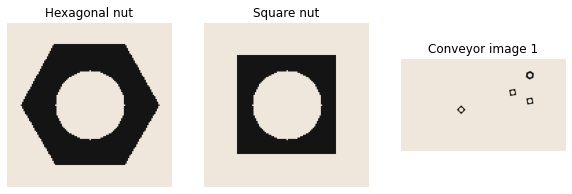

In [2]:
hexnut_template = cv.imread('hexnut_template.png', cv.IMREAD_COLOR)
squarenut_template = cv.imread('squarenut_template.png', cv.IMREAD_COLOR)
conveyor_f100 = cv.imread('conveyor_f100.png', cv.IMREAD_COLOR)

hexnut_template = cv.cvtColor(hexnut_template, cv.COLOR_BGR2RGB)
squarenut_template = cv.cvtColor(squarenut_template, cv.COLOR_BGR2RGB)
conveyor_f100 = cv.cvtColor(conveyor_f100, cv.COLOR_BGR2RGB)

fig, ax = plt. subplots(1,3, figsize=(10, 10))
ax[0].imshow(hexnut_template)
ax[0].set_title("Hexagonal nut")
ax[0].axis("off")
ax[1].imshow(squarenut_template)
ax[1].set_title("Square nut")
ax[1].axis("off")
ax[2].imshow(conveyor_f100)
ax[2].set_title("Conveyor image 1")
ax[2].axis("off")
plt.show()


##### Thresholding with otsu algorithm 

In [3]:
hexnut_template_gray = cv.cvtColor(hexnut_template, cv.COLOR_RGB2GRAY)
squarenut_template_gray = cv.cvtColor(squarenut_template, cv.COLOR_RGB2GRAY)
conveyor_f100_gray = cv.cvtColor(conveyor_f100, cv.COLOR_RGB2GRAY)

ret0,hexnut_template_gray = cv.threshold(hexnut_template_gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
ret1,squarenut_template_gray = cv.threshold(squarenut_template_gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
ret2,conveyor_f100_gray = cv.threshold(conveyor_f100_gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

print("Threshold for hexagonal nut template:", ret0)
print("Threshold for square nut template:", ret1)
print("Threshold for conveyor:", ret2)

Threshold for hexagonal nut template: 20.0
Threshold for square nut template: 20.0
Threshold for conveyor: 20.0


##### Marphological closing

In [4]:
kernel = np.ones((3,3), np.uint8)

hexnut_template_gray = cv.morphologyEx(hexnut_template_gray, cv.MORPH_CLOSE, kernel)
squarenut_template_gray = cv.morphologyEx(squarenut_template_gray, cv.MORPH_CLOSE, kernel)
conveyor_f100_gray = cv.morphologyEx(conveyor_f100_gray, cv.MORPH_CLOSE, kernel)

In [5]:
def create_table(retval, stats, centroids):
    if retval == 2: print("Only a single component is detected")
    else: print("There are", retval-1, "components are detected excluding the background.")

    table = {
                'Name': ["Component " + str(i) for i in range(1, retval)],
                "X coordinate": stats[1:, 0],
                "Y coordinate": stats[1:, 1],
                "Length in X direction": stats[1:, 2],
                "Length in y direction": stats[1:, 3],
                "Area": stats[1:, 4],
                "Centroid": ["({}, {})".format(round(center[0], 3), round(center[1], 3)) for center in centroids[1:]]
            }
    df = pd.DataFrame(table)     
    return df

##### Connected component analysis for hexagonal nut

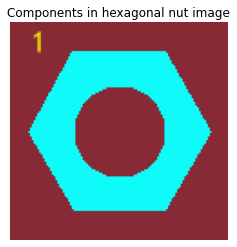

Only a single component is detected


,Name,X coordinate,Y coordinate,Length in X direction,Length in y direction,Area,Centroid
0,Component 1,10,16,101,88,4728,"(59.834, 59.224)"


In [33]:
retval, labels, stats, centroids = cv.connectedComponentsWithStats(hexnut_template_gray)
colormapped = cv.applyColorMap((labels/np.amax(labels)*255).astype('uint8'), cv.COLORMAP_PARULA)

for i, s in enumerate(stats):
    if i !=0:
        cv.putText(colormapped, "{}".format(i), (s[0], s[1]), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1, cv.LINE_AA)

plt.imshow(colormapped)
plt.title("Components in hexagonal nut image")
plt.axis('off')
plt.show()
create_table(retval, stats, centroids)

##### Connected component analysis for square nut

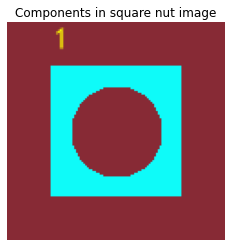

Only a single component is detected


,Name,X coordinate,Y coordinate,Length in X direction,Length in y direction,Area,Centroid
0,Component 1,24,24,72,72,3227,"(59.197, 59.197)"


In [29]:
retval, labels, stats, centroids = cv.connectedComponentsWithStats(squarenut_template_gray)
colormapped = cv.applyColorMap((labels/np.amax(labels)*255).astype('uint8'), cv.COLORMAP_PARULA)

for i, s in enumerate(stats):
    if i !=0:
        cv.putText(colormapped, "{}".format(i), (s[0], s[1]-10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1, cv.LINE_AA)

plt.imshow(colormapped)
plt.title("Components in square nut image")
plt.axis('off')
plt.show()
create_table(retval, stats, centroids)

##### Connected component analysis for conveyor image 1

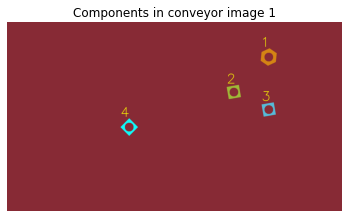

There are 4 components are detected excluding the background.


,Name,X coordinate,Y coordinate,Length in X direction,Length in y direction,Area,Centroid
0,Component 1,1454,150,92,100,4636,"(1499.242, 199.285)"
1,Component 2,1259,359,82,82,3087,"(1299.183, 399.183)"
2,Component 3,1459,459,82,82,3087,"(1499.183, 499.183)"
3,Component 4,650,550,101,101,3144,"(700.0, 600.0)"


In [28]:
retval, labels, stats, centroids = cv.connectedComponentsWithStats(conveyor_f100_gray)
colormapped = cv.applyColorMap((labels/np.amax(labels)*255).astype('uint8'), cv.COLORMAP_PARULA)

for i, s in enumerate(stats):
    if i !=0:
        cv.putText(colormapped, "{}".format(i), (s[0], s[1]-10), cv.FONT_HERSHEY_SIMPLEX, 2.5, (255, 255, 0), 2, cv.LINE_AA)

plt.imshow(colormapped)
plt.title("Components in conveyor image 1")
plt.axis('off')
plt.show()
create_table(retval, stats, centroids)

##### Contour detection

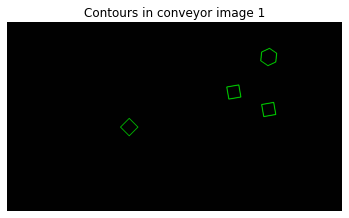

In [9]:
conveyor_f100_shape = np.ones_like(conveyor_f100)

conveyor_f100_contours, hierarchy = cv.findContours(conveyor_f100_gray, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(conveyor_f100_shape, conveyor_f100_contours, -1, (0,255,0), 3)

plt.imshow(conveyor_f100_shape)
plt.title("Contours in conveyor image 1")
plt.axis('off')
plt.show()

### Detecting Objects on a Synthetic Conveyor

In [10]:
hexnut_template_contours, hierarchy = cv.findContours(hexnut_template_gray, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
hexnut_template_contours = hexnut_template_contours[0]
squarenut_template_contours, hierarchy = cv.findContours(squarenut_template_gray, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
squarenut_template_contours = squarenut_template_contours[0]

In [11]:
hexnuts, squarenuts = [], []
thres = 1/1000

for index, contour in enumerate(conveyor_f100_contours):
    score = cv.matchShapes(squarenut_template_contours,contour,1,0.0)
    if score < thres: squarenuts.append(index)

    score = cv.matchShapes(hexnut_template_contours,contour,1,0.0)
    if score < thres: hexnuts.append(index)


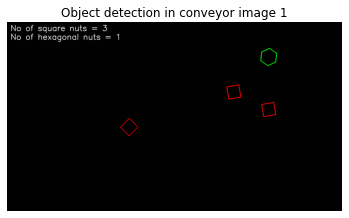

In [12]:
conveyor_f100_shape = np.ones_like(conveyor_f100)

for index in hexnuts:
    cv.drawContours(conveyor_f100_shape, conveyor_f100_contours, index, (0, 255, 0), 3)

for index in squarenuts:
    cv.drawContours(conveyor_f100_shape, conveyor_f100_contours, index, (255, 0 ,0), 3)

cv.putText(conveyor_f100_shape, "No of square nuts = {}".format(len(squarenuts)), (20, 50), cv.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv.LINE_AA)
cv.putText(conveyor_f100_shape, "No of hexagonal nuts = {}".format(len(hexnuts)), (20, 100), cv.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv.LINE_AA)

plt.imshow(conveyor_f100_shape)
plt.title("Object detection in conveyor image 1")
plt.axis('off')
plt.show()

In [13]:
cv.namedWindow('Conveyor', cv.WINDOW_NORMAL)
cap = cv.VideoCapture('conveyor.mp4')
frame = []   
frame_array = []   
thres, max_distance, previous_max_distance, hex_count, square_count = 1/1000, None, 0, 0, 0

while cap.isOpened():                                    
    ret, frame = cap.read()
    if not ret:
        print("Done")
        break

    _img = np.copy(frame)
    _img = cv.cvtColor(_img, cv.COLOR_BGR2GRAY)
    ret, _img = cv.threshold(_img,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    _img = cv.morphologyEx(_img, cv.MORPH_CLOSE, kernel)
    retval, labels, stats, centroids = cv.connectedComponentsWithStats(_img)
    contours, hierarchy = cv.findContours(_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    hexnuts, squarenuts = [], []
    
    if retval > 1:
        max_distance = np.floor(np.max(centroids[1:, 0][centroids[1:, 0] <= 1875]))
        indexes = np.where(np.floor(centroids[1:, 0]) == max_distance)
        if max_distance >= previous_max_distance:
            previous_max_distance = max_distance
            for index in indexes[0]:
                area = stats[int(index)+1, 4]
                if 5000 > area > 4000: hex_count += 1
                if 4000 > area > 3000: square_count += 1 

    for index, contour in enumerate(contours):
        score = cv.matchShapes(squarenut_template_contours,contour,1,0.0)
        if score < thres: squarenuts.append(index)
        score = cv.matchShapes(hexnut_template_contours,contour,1,0.0)
        if score < thres: hexnuts.append(index)

    cv.putText(frame, "No of square nuts in the frame= {}".format(len(squarenuts)), (20, 50), cv.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2, cv.LINE_AA)
    cv.putText(frame, "No of hexagonal nuts in the frame= {}".format(len(hexnuts)), (20, 100), cv.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2, cv.LINE_AA)
    cv.putText(frame, "Total square nuts = {}".format(square_count), (20, 150), cv.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2, cv.LINE_AA)
    cv.putText(frame, "Total hexagonal nuts = {}".format(hex_count), (20, 200), cv.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2, cv.LINE_AA)

    cv.imshow('Conveyor', frame)
    frame_array.append(frame)
    if cv.waitKey(1) == ord('q'):  
        break

cap.release()
cv.destroyAllWindows()

Done


In [14]:
shape = (1080, 1920, 3)
out = cv.VideoWriter('./conveyor_result_190610E.mp4',cv.VideoWriter_fourcc(*'h264'), 30, (shape[1], shape[0]))
 
for i in range(len(frame_array)):
    out.write(frame_array[i])

out.release()
cv.destroyAllWindows()